**AIM 5001 (Spring 2021)**

**Module 12 Assignment - Text Mining and Pre-Processing Movie Reviews**

**Atreish Ramlakhan, Aishwarya Singh, Nosson Weissman**

# Introduction

As we’ve learned, many organizations rely on sentiment analysis algorithms to help them gauge the opinions 
of both existing and potential customers. For example, companies such as Amazon, TripAdvisor, Booking.com, 
WalMart, and Yelp (amongst others) apply sentiment analysis algorithms to the online product/service 
reviews provided by their customers to better understand how the public perceives competing products and 
services.

Our task for the Module 12 Assignment is to prepare a collection of text documents for use within a sentiment analysis algorithm. We are working with a set of 1000 positive and 1000 negative movie reviews, wherein each movie review is in the form of freeform text captured from website postings. In this assignment, we make use of pre-processing techniques to prepare the content of the reviews for use within a machine-learning classification model.

# Data Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
import string

We begin by extracting the tar.gz file containing our movie reviews from GitHub to the local working directory.

In [2]:
import urllib.request
import tarfile

path = 'https://raw.githubusercontent.com/codepharmer/AIM-5001/main/Module_12/review_polarity.tar.gz'
thetarfile = path
ftpstream = urllib.request.urlopen(thetarfile)
thetarfile = tarfile.open(fileobj=ftpstream, mode='r|gz')
thetarfile.extractall('.')
gz_dir = set([line.split('/')[0] for line in thetarfile.getnames()])

We now load in the positive and negative reviews separately. We remove punctuation and tokenize each file as it is loaded using nltk's RegexpTokenizer functionality.

In [3]:
import os
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

def get_textfiles_from_dir(path):
    filenames = next(os.walk(path))[2]
    files = []
    for name in filenames:
        files.append( tokenizer.tokenize(open((path + '/' + name), 'r').read()) )
    return files

pos = get_textfiles_from_dir('./txt_sentoken/pos')
neg = get_textfiles_from_dir('./txt_sentoken/neg')

Some basic checks are performed to ensure that the data loaded successfully.

In [4]:
print(pos[0][:10])

['films', 'adapted', 'from', 'comic', 'books', 'have', 'had', 'plenty', 'of', 'success']


In [5]:
print(neg[0][:10])

['plot', 'two', 'teen', 'couples', 'go', 'to', 'a', 'church', 'party', 'drink']


In [6]:
len(pos)

1000

In [7]:
len(neg)

1000

The nltk English stopwords collection is used to filter out stopwords from our review data.

In [8]:
from nltk.corpus import stopwords

en_stops = set(stopwords.words('english'))

for i in range(len(pos)):
    pos[i] = [word for word in pos[i] if word not in en_stops]
    neg[i] = [word for word in neg[i] if word not in en_stops]

print(pos[0][:10])

['films', 'adapted', 'comic', 'books', 'plenty', 'success', 'whether', 'superheroes', 'batman', 'superman']


In [9]:
print(neg[0][:10])

['plot', 'two', 'teen', 'couples', 'go', 'church', 'party', 'drink', 'drive', 'get']


## Term-Document Matrix

Now we create a term-document matrix from our cleaned movie reviews. We start by creating a set of tokens for the entire corpus of text; we could do this by creating an empty set and iteratively filling it, but instead we create a list and use nltk.FreqDist() so that we can get a picture of what some of the most frequent words in our data set are.

In [10]:
all_words = []
pos_words = []
neg_words = []

for review in pos:
    for word in review:
        all_words.append(word)
        pos_words.append(word)

for review in neg:
    for word in review:
        all_words.append(word)
        neg_words.append(word)

freq = nltk.FreqDist(all_words)
freq

FreqDist({'film': 9517, 'one': 5852, 'movie': 5771, 'like': 3690, 'even': 2565, 'good': 2411, 'time': 2411, 'story': 2169, 'would': 2109, 'much': 2049, ...})

In [11]:
print(all_words[:10])

['films', 'adapted', 'comic', 'books', 'plenty', 'success', 'whether', 'superheroes', 'batman', 'superman']


The length of 'freq' is the number of unique tokens in our corpus of text.

In [12]:
len(freq)

39545

Now we create the term document matrix, initially by just casting the 'freq' dict into a pandas DataFrame. This way we get all of the tokens in our entire corpus as column labels.

In [13]:
termDoc = pd.DataFrame(freq, index = [0])

termDoc

,films,adapted,comic,books,plenty,success,whether,superheroes,batman,superman,...,_roxbury_,pelvic,butabis,fortenberry,_21_jump_street_,obeys,rift,stonily,_jerry_maguire_,_have_
0,1536,46,389,78,134,216,217,12,203,26,...,3,1,1,1,1,1,1,1,2,1


We add one column for labeling each review as positive or negative.

In [14]:
termDoc.insert(0, 'pos/neg', value = ['pos'])

termDoc

,pos/neg,films,adapted,comic,books,plenty,success,whether,superheroes,batman,...,_roxbury_,pelvic,butabis,fortenberry,_21_jump_street_,obeys,rift,stonily,_jerry_maguire_,_have_
0,pos,1536,46,389,78,134,216,217,12,203,...,3,1,1,1,1,1,1,1,2,1


Finally, we create the term-document matrix representing all 2000 reviews, then fill missing values with zeroes (since the missing values in this situation actually do represent zero counts).

In [15]:
biglist = []

for review in pos:
    rfreq = nltk.FreqDist(review)
    rfreq['pos/neg'] = 'pos' # Use the fact that FreqDist() returns a dict
    biglist.append(rfreq)

for review in neg:
    rfreq = nltk.FreqDist(review)
    rfreq['pos/neg'] = 'neg'
    biglist.append(rfreq)

len(biglist)

2000

In [16]:
termDoc.drop(axis = 0, index = 0, inplace = True) # Get rid of the original top row (entire-corpus freq)
termDoc = termDoc.append(biglist)
termDoc.fillna(0, inplace = True)

Check to see if our term-document matrix has formed correctly.

In [17]:
termDoc.head()

,pos/neg,films,adapted,comic,books,plenty,success,whether,superheroes,batman,...,_roxbury_,pelvic,butabis,fortenberry,_21_jump_street_,obeys,rift,stonily,_jerry_maguire_,_have_
0,pos,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,pos,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,pos,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,pos,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,pos,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
termDoc.tail()

,pos/neg,films,adapted,comic,books,plenty,success,whether,superheroes,batman,...,_roxbury_,pelvic,butabis,fortenberry,_21_jump_street_,obeys,rift,stonily,_jerry_maguire_,_have_
1995,neg,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1996,neg,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1997,neg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1998,neg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1999,neg,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0


In [19]:
termDoc.shape

(2000, 39546)

# Matrix Sparsity Calculation

We drop the pos/neg label column, then convert our pandas DataFrame to a 2-dimensional numpy array.

In [20]:
termDoc2 = termDoc.drop('pos/neg', axis = 1)

the_matrix = termDoc2.to_numpy()

the_matrix.shape

(2000, 39545)

'Sparsity' is defined by the number of zero-valued elements in a matrix divided by the total number of elements. We use numpy's count_nonzero() function to find the count of _non-zero_ elements to ease our calculation, however, as a count_zero() function does not exist.

In [21]:
nonzero = np.count_nonzero(the_matrix)

nonzero

537514

In [22]:
total = the_matrix.shape[0] * the_matrix.shape[1]

total

79090000

In [23]:
sparsity = (total - nonzero)/total

print('Sparsity =', sparsity*100, '%')

Sparsity = 99.32037678594007 %


# Frequency Distribution Plots

For the creation of frequency distribution plots from the pandas DataFrames explicitly (as opposed to nltk FreqDist() function), we break the DataFrame into positive-only and negative-only halves.

In [24]:
termDocP = pd.DataFrame(termDoc[termDoc['pos/neg'] == 'pos'])
termDocP.drop('pos/neg', axis = 1, inplace = True)

termDocP.tail()

,films,adapted,comic,books,plenty,success,whether,superheroes,batman,superman,...,_roxbury_,pelvic,butabis,fortenberry,_21_jump_street_,obeys,rift,stonily,_jerry_maguire_,_have_
995,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
termDocN = pd.DataFrame(termDoc[termDoc['pos/neg'] == 'neg'])
termDocN.drop('pos/neg', axis = 1, inplace = True)

termDocN.head()

,films,adapted,comic,books,plenty,success,whether,superheroes,batman,superman,...,_roxbury_,pelvic,butabis,fortenberry,_21_jump_street_,obeys,rift,stonily,_jerry_maguire_,_have_
1000,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We collect the total appearance counts of each token in dicts, then sort the dicts and split them into keys and values for plotting purposes. This is repeated for the positive and negative reviews.

In [26]:
freqP = {}

for i in termDocP.columns:
    freqP[i] = termDocP[i].sum()

freqP['film']

5230.0

In [27]:
P_keys = []
P_vals = []

for k in sorted(freqP, key = freqP.get, reverse = True)[:30]:
    P_keys.append(k)
    P_vals.append(freqP[k])

print(P_keys[0])
print(P_vals[0])

film
5230.0


In [28]:
freqN = {}

for i in termDocN.columns:
    freqN[i] = termDocN[i].sum()

freqN['film']

4287.0

In [29]:
N_keys = []
N_vals = []

for k in sorted(freqN, key = freqN.get, reverse = True)[:30]:
    N_keys.append(k)
    N_vals.append(freqN[k])

print(N_keys[0])
print(N_vals[0])

film
4287.0


Now we plot first the frequency distribution for the positive reviews, then for the negative reviews.

In [30]:
import seaborn as sns

<AxesSubplot:title={'center':'Positive Review Frequencies'}, ylabel='Count'>

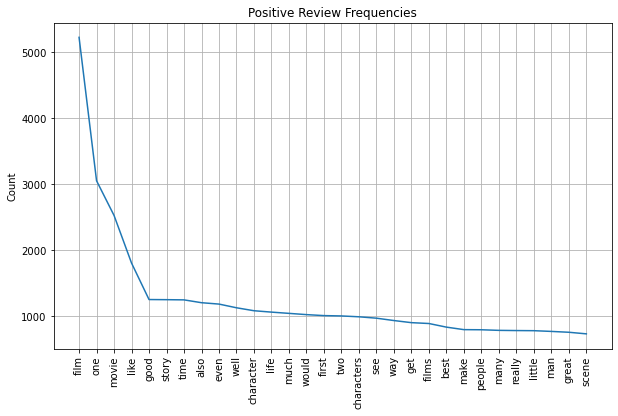

In [31]:
plt.figure(figsize = (10,6))
plt.title('Positive Review Frequencies')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.grid(True)
sns.lineplot(x = P_keys, y = P_vals)

<AxesSubplot:title={'center':'Negative Review Frequencies'}, ylabel='Count'>

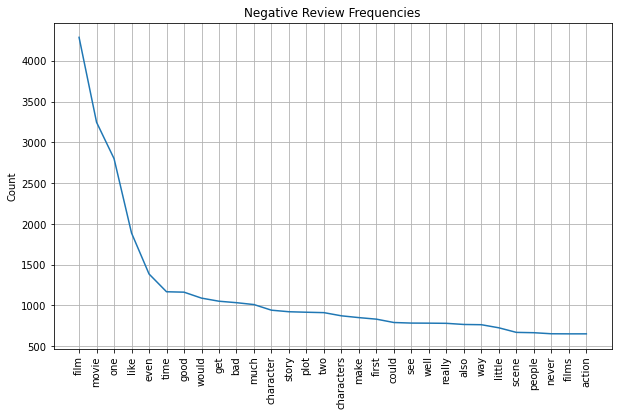

In [32]:
plt.figure(figsize = (10,6))
plt.title('Negative Review Frequencies')
plt.ylabel('Count')
plt.xticks(rotation = 90)
plt.grid(True)
sns.lineplot(x = N_keys, y = N_vals)

The first insight that stands out is that a lot of generic movie-related terms like 'film' and 'movie' are very common in both positive and negative reviews. More emphatically positive terms like 'great' and 'best' only make the top 30 tokens for positive labeled reviews though, while an explicitly negative term 'bad' is quite frequent for negative labeled reviews. Interestingly, a positive word 'good' appears very frequently even in the negative reviews, and actually has a very similar count in both review categories.

# Sentiment Analysis Model Preparation

We start our sentiment analysis model prep by randomly extracting 75% of our term-document data to act as a training set.

In [33]:
training_set = termDoc.sample(n = 1500)
training_set

,pos/neg,films,adapted,comic,books,plenty,success,whether,superheroes,batman,...,_roxbury_,pelvic,butabis,fortenberry,_21_jump_street_,obeys,rift,stonily,_jerry_maguire_,_have_
809,pos,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,pos,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
179,pos,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
986,pos,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
375,pos,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1943,neg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1957,neg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1802,neg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1046,neg,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
# How many positive reviews in our training set?
p = len(training_set[(training_set['pos/neg'] == 'pos')])

print('Positive Reviews in Training Set =', p)
print('Positive Percent in Training Set =', p/15, '%')

Positive Reviews in Training Set = 759
Positive Percent in Training Set = 50.6 %


In [35]:
# How many negative reviews in our training set?
n = 1500 - p

print('Negative Reviews in Training Set =', n)
print('Negative Percent in Training Set =', n/15, '%')

Negative Reviews in Training Set = 741
Negative Percent in Training Set = 49.4 %


Now we create our testing set where we select the remaining 25% of the original term-document matrix.

In [36]:
# Create a list for the index of the rows in our trianing set
tr_index = training_set.index
tr_index.tolist()[:10]

[809, 93, 179, 986, 375, 620, 621, 205, 1946, 1017]

In [37]:
# To create our testing set of 500 rows, we ensure that the index form termDoc is not matching in training_set
ix = [i for i in termDoc.index if i not in tr_index]  
test_set = termDoc.loc[ix]
test_set

,pos/neg,films,adapted,comic,books,plenty,success,whether,superheroes,batman,...,_roxbury_,pelvic,butabis,fortenberry,_21_jump_street_,obeys,rift,stonily,_jerry_maguire_,_have_
0,pos,1.0,1.0,5.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,pos,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,pos,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,pos,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,pos,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1980,neg,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985,neg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1993,neg,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1994,neg,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# How many positive reviews in our testing set?
p = len(test_set[(test_set['pos/neg'] == 'pos')])

print('Positive Reviews in Testing Set =', p)
print('Positive Percent in Testing Set =', p/5, '%')

# How many negative reviews in our testing set?
n = 500 - p

print('Negative Reviews in Testing Set =', n)
print('Negative Percent in Testing Set =', n/5, '%')

Positive Reviews in Testing Set = 241
Positive Percent in Testing Set = 48.2 %
Negative Reviews in Testing Set = 259
Negative Percent in Testing Set = 51.8 %


The proportion of positive and negative reviews in both our training and testing sets are very close to 50% each. As such, we can make a reasonable assumption that, since they are randomized by the pandas sample() function, these training set and test set DataFrames will provide the sentiment analysis model a balanced starting point from which to classify future reviews.